In [138]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Load Data

In [8]:
#load data from local folder

basics_local='Data/title_basics_filtered.csv.gz'
ratings_local='Data/title_ratings_filtered.csv.gz'
aka_local='Data/title_akas_filtered.csv.gz'

In [9]:
df_basics = pd.read_csv(basics_local)
df_ratings = pd.read_csv(ratings_local)
df_aka = pd.read_csv(aka_local)

In [10]:
df_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82213 entries, 0 to 82212
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          82213 non-null  object 
 1   titleType       82213 non-null  object 
 2   primaryTitle    82213 non-null  object 
 3   originalTitle   82213 non-null  object 
 4   isAdult         82213 non-null  int64  
 5   startYear       82213 non-null  float64
 6   endYear         0 non-null      float64
 7   runtimeMinutes  82213 non-null  int64  
 8   genres          82213 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [11]:
df_aka.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343796 entries, 0 to 1343795
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1343796 non-null  object 
 1   ordering         1343796 non-null  int64  
 2   title            1343796 non-null  object 
 3   region           1343796 non-null  object 
 4   language         3685 non-null     object 
 5   types            963507 non-null   object 
 6   attributes       44791 non-null    object 
 7   isOriginalTitle  1342421 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 82.0+ MB


In [12]:
#Ratings didn't need any addtional data preparation
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255994 entries, 0 to 1255993
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1255994 non-null  object 
 1   averageRating  1255994 non-null  float64
 2   numVotes       1255994 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.7+ MB


In [13]:
df_aka.groupby('region').count()

,titleId,ordering,title,language,types,attributes,isOriginalTitle
region,,,,,,,
US,1343796,1343796,1343796,3685,963507,44791,1342421


In [14]:
import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook
FOLDER = "Data/"

In [15]:
with open('/Users/JoseH/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()


dict_keys(['client-id', 'api-key'])

In [16]:
tmdb.API_KEY =  login['api-key']

In [17]:
def write_json(new_data, filename): 
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""    
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [18]:
def movie_data(id):
    # Get the movie object for the current id
    movie = tmdb.Movies(id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
           info['certification'] = c['certification']
    return info

## Load data from 5 years before the pandemic

In [25]:
years=[]
for i in range(2015,2020,1):
    years.append(i)
years

[2015, 2016, 2017, 2018, 2019]

In [26]:
for YEAR in tqdm_notebook(years,desc='YEARS',position=0):
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    #Saving new year as the current df
    df = df_basics.loc[ df_basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()#.to_list()
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        # Attempt to retrieve then data for the movie id
        try:
            temp = movie_data(movie_id)  #This uses your pre-made function
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        # If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            continue
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/5 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/4930 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5140 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5503 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5630 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5726 [00:00<?, ?it/s]

In [28]:
files_combined=[]
for YEAR in years:
    JSON_FILE = f'Data/tmdb_api_results_{YEAR}.json'
    with open(JSON_FILE, 'r') as file:
            files_combined.extend(json.load(file))

In [248]:
df_combined=pd.DataFrame(files_combined)
df_combined.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0191476,False,None,None,0.0,"[{'id': 35, 'name': 'Comedy'}]",,365165.0,ro,Această lehamite,...,0.000000e+00,98.0,"[{'english_name': 'Romanian', 'iso_639_1': 'ro...",Released,,Fed Up,False,4.400,5.0,NaN
2,tt0369610,False,/dF6FjTZzRTENfB4R17HDN20jLT2.jpg,"{'id': 328, 'name': 'Jurassic Park Collection'...",150000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.jurassicworld.com/,135397.0,en,Jurassic World,...,1.671713e+09,124.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The park is open.,Jurassic World,False,6.675,18412.0,PG-13
3,tt0420293,False,/b0p0OPx1ZDZVc8iDB1kle0Cc2H9.jpg,None,0.0,"[{'id': 53, 'name': 'Thriller'}]",http://www.stanfordprisonexperimentfilm.com/,308032.0,en,The Stanford Prison Experiment,...,6.435570e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They were given 2 weeks. It lasted 6 days.,The Stanford Prison Experiment,False,6.900,813.0,R
4,tt0462335,False,/wESuRMxELPAwo56qFRcoyI4p20F.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.highrisefilm.com,254302.0,en,High-Rise,...,3.464720e+05,119.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,Leave the real world behind,High-Rise,False,5.655,983.0,R


## Data loaded for Hypotesis

In [144]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21270 entries, 0 to 21269
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                21270 non-null  object 
 1   adult                  21265 non-null  object 
 2   backdrop_path          15333 non-null  object 
 3   belongs_to_collection  1252 non-null   object 
 4   budget                 21265 non-null  float64
 5   genres                 21265 non-null  object 
 6   homepage               21265 non-null  object 
 7   id                     21265 non-null  float64
 8   original_language      21265 non-null  object 
 9   original_title         21265 non-null  object 
 10  overview               21265 non-null  object 
 11  popularity             21265 non-null  float64
 12  poster_path            20411 non-null  object 
 13  production_companies   21265 non-null  object 
 14  production_countries   21265 non-null  object 
 15  re

In [145]:

## Checking Certification values counts
df_combined['certification'].value_counts(dropna = False)

NaN        9674
           7535
R          1446
NR         1177
PG-13       855
PG          399
G           132
NC-17        48
Unrated       4
Name: certification, dtype: int64

# Hypothesis 1

Null hypothesis: All ratings does not have any significance difference based on revenue

Alternative Hypothesis: There is significance difference based on revenue for the different ratings

**Ratings to test ['PG-13', 'R', 'PG', 'NR', 'G'] **

## Data Manipulation to test hypothesis

In [146]:
df_revenue=df_combined.loc[df_combined['revenue']>0]
df_revenue.shape

(2200, 26)

In [171]:
df_revenue_cert=df_revenue.dropna(subset=['certification'])
df_revenue.shape

(2200, 26)

In [172]:
df_revenue_cert['certification'].value_counts(dropna = False)

R        565
PG-13    407
         366
PG       154
NR        75
G         32
NC-17      7
Name: certification, dtype: int64

## Taking out blank ratings and NC-17 

NC 17 doesn't have enough records for the hypothesis testing

In [173]:

df_rev_cert=df_revenue_cert.loc[df_revenue_cert['certification'].str.len()>0]
df_rev_cert=df_rev_cert.loc[~(df_rev_cert['certification']=="NC-17")]

In [174]:
df_rev_cert=df_rev_cert[['certification','revenue']]

In [175]:
df_rev_cert['certification'].value_counts(dropna = False)

R        565
PG-13    407
PG       154
NR        75
G         32
Name: certification, dtype: int64

## Splitting Ratings into groups

In [176]:

groups = {}
## Loop through all unique categories
for i in df_rev_cert['certification'].unique():
    ## Get series for group and rename
    data = df_rev_cert.loc[df_rev_cert['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG-13', 'R', 'PG', 'NR', 'G'])

## Taking out outliers

In [177]:
for i in df_rev_cert['certification'].unique():
    groups[i] = groups[i][(np.abs(stats.zscore(groups[i])) < 3)]

## Normality Test

In [178]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,398.0,5.554947e-45,203.803280
R,553.0,6.806770e-73,332.341588
PG,150.0,6.185648e-16,70.038259
NR,73.0,5.892614e-09,37.899132
G,31.0,7.192229e-10,42.105699


The groups doesn't have normal distributions, but based in the amount of observations in each sample, we can ignore the normality assumption (n>=15)

## Variance Test

In [155]:
stats.levene(*groups.values())

LeveneResult(statistic=35.179240426689475, pvalue=8.175008245149918e-28)

Variance test not passed, a non-parametric test is needed to test hypothesis

## Hypothesis Test

In [180]:
results = stats.kruskal(*groups.values())
results


KruskalResult(statistic=161.85969752179176, pvalue=5.835195553732642e-34)

P value is below 5% alpha meaning that the null hypothesis can be rejected. There is significant difference between ratings

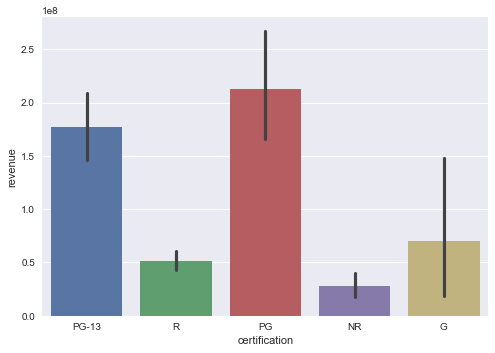

In [162]:
sns.barplot(data=df_rev_cert,x='certification',y='revenue');

The ratings that earn more revenue are PG and PG-13

# Hypothesis 2

Null hypothesis: Movies released in 2018 and movies released in 2019 doesn't have any significant difference in revenue



Alternative Hypothesis: There is significance difference for movies released in 2018 and movies that were released in 2019.


In [282]:
df_combined.isna().sum()

imdb_id                      0
adult                        5
backdrop_path             5937
belongs_to_collection    20018
budget                       5
genres                       5
homepage                     5
id                           5
original_language            5
original_title               5
overview                     5
popularity                   5
poster_path                859
production_companies         5
production_countries         5
release_date                 5
revenue                      5
runtime                      5
spoken_languages             5
status                       5
tagline                      5
title                        5
video                        5
vote_average                 5
vote_count                   5
certification             9674
year                         5
month                      351
day                        351
dtype: int64

In [283]:
df_combined[['year','month','day']]=df_combined['release_date'].str.split("-",expand=True)           

## Data manipulation

In [288]:
df_years=df_combined.dropna(subset=['year'])

df_years=df_years.loc[df_years['revenue']>0]

df_years.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,certification,year,month,day
2,tt0369610,False,/dF6FjTZzRTENfB4R17HDN20jLT2.jpg,"{'id': 328, 'name': 'Jurassic Park Collection'...",150000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.jurassicworld.com/,135397.0,en,Jurassic World,...,Released,The park is open.,Jurassic World,False,6.675,18412.0,PG-13,2015,06,06
3,tt0420293,False,/b0p0OPx1ZDZVc8iDB1kle0Cc2H9.jpg,None,0.0,"[{'id': 53, 'name': 'Thriller'}]",http://www.stanfordprisonexperimentfilm.com/,308032.0,en,The Stanford Prison Experiment,...,Released,They were given 2 weeks. It lasted 6 days.,The Stanford Prison Experiment,False,6.900,813.0,R,2015,07,17
4,tt0462335,False,/wESuRMxELPAwo56qFRcoyI4p20F.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.highrisefilm.com,254302.0,en,High-Rise,...,Released,Leave the real world behind,High-Rise,False,5.655,983.0,R,2015,11,22
5,tt0478970,False,/1K3JmSNUN8OpjYsCjc0Hy0SYxAb.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",130000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/movies/movie/180/ant-man,102899.0,en,Ant-Man,...,Released,Heroes don't get any bigger.,Ant-Man,False,7.100,17436.0,PG-13,2015,07,14
6,tt0787524,False,/cJ6dqrHhts085zJTMaXECjp0RfX.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.ifcfilms.com/films/the-man-who-knew...,353326.0,en,The Man Who Knew Infinity,...,Released,What does it take to prove the impossible?,The Man Who Knew Infinity,False,7.185,1192.0,PG-13,2016,04,08


In [285]:
y2019_df=df_years.loc[df_years['year']=='2019',['revenue']]
y2018_df=df_years.loc[df_years['year']=='2018',['revenue']]

y2019=y2019_df['revenue']
y2018=y2018_df['revenue']

display(y2019.shape,y2018.shape)

(392,)

(412,)

## Outliers Check

In [286]:
y2019 = y2019[(np.abs(stats.zscore(y2019)) < 3)]
y2018 = y2018[(np.abs(stats.zscore(y2018)) < 3)]
display(y2019.shape,y2018.shape)

(382,)

(403,)

## Normality Test

In [279]:
y2019_result = stats.normaltest(y2019)
y2018_result = stats.normaltest(y2018)
display(y2019_result,y2018_result)

NormaltestResult(statistic=338.4662921861445, pvalue=3.1840398655374443e-74)

NormaltestResult(statistic=297.19333653694036, pvalue=2.9193552179982727e-65)

Both samples doesn't have normal distributions, but based in the amount of observations in each sample, we can ignore the normality assumption (n>15)

## Equal Variance Test

In [280]:
result = stats.levene(y2019,y2018)
result

LeveneResult(statistic=0.6754725198999, pvalue=0.41140030501109104)

Variance is the same for both samples

## Hypothesis Test

In [281]:
 stats.ttest_ind(y2019, y2018)

Ttest_indResult(statistic=-0.8687764625362723, pvalue=0.38523562040123005)

P value is above 5% alpha meaning that we cannot reject the null hypothesis

In [305]:
y2019_df

,revenue
7803,111353135.0
9823,140000.0
12218,600654.0
12280,6424420.0
12288,130000.0
...,...
21123,2197075.0
21133,1964806.0
21175,15712.0
21194,103047.0


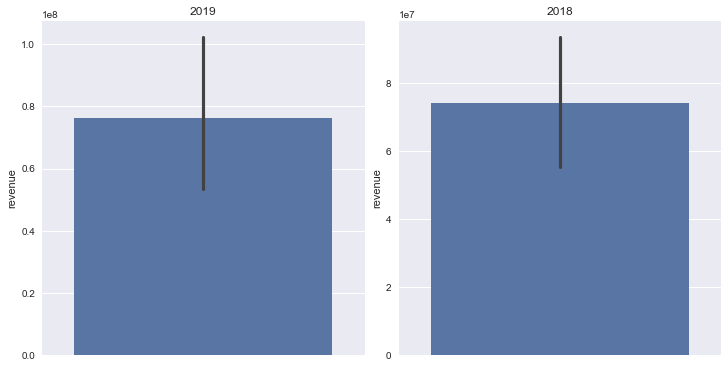

In [314]:
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.5,0.5]})
sns.barplot(data=y2019_df, y='revenue',ax = ax).set(title='2019')
b=sns.barplot(data=y2018_df, y='revenue',ax = ax_bar).set(title='2018')


# Hypothesis 3


Null hypothesis: Movies that are over 2.5 hours and movies that are 1.5 hours long or less) doesn't have any significant difference in revenue



Alternative Hypothesis: There is significance difference for movies that are over 2.5 hours and movies that are 1.5 hours long or less


In [200]:
df_combined.isna().sum()

imdb_id                      0
adult                        5
backdrop_path             5937
belongs_to_collection    20018
budget                       5
genres                       5
homepage                     5
id                           5
original_language            5
original_title               5
overview                     5
popularity                   5
poster_path                859
production_companies         5
production_countries         5
release_date                 5
revenue                      5
runtime                      5
spoken_languages             5
status                       5
tagline                      5
title                        5
video                        5
vote_average                 5
vote_count                   5
certification             9674
dtype: int64

## Data manipulation

In [297]:
df_runtime=df_combined.dropna(subset=['runtime'])

df_runtime=df_runtime.loc[df_runtime['revenue']>0]

df_runtime.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,certification,year,month,day
2,tt0369610,False,/dF6FjTZzRTENfB4R17HDN20jLT2.jpg,"{'id': 328, 'name': 'Jurassic Park Collection'...",150000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.jurassicworld.com/,135397.0,en,Jurassic World,...,Released,The park is open.,Jurassic World,False,6.675,18412.0,PG-13,2015,06,06
3,tt0420293,False,/b0p0OPx1ZDZVc8iDB1kle0Cc2H9.jpg,None,0.0,"[{'id': 53, 'name': 'Thriller'}]",http://www.stanfordprisonexperimentfilm.com/,308032.0,en,The Stanford Prison Experiment,...,Released,They were given 2 weeks. It lasted 6 days.,The Stanford Prison Experiment,False,6.900,813.0,R,2015,07,17
4,tt0462335,False,/wESuRMxELPAwo56qFRcoyI4p20F.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.highrisefilm.com,254302.0,en,High-Rise,...,Released,Leave the real world behind,High-Rise,False,5.655,983.0,R,2015,11,22
5,tt0478970,False,/1K3JmSNUN8OpjYsCjc0Hy0SYxAb.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",130000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/movies/movie/180/ant-man,102899.0,en,Ant-Man,...,Released,Heroes don't get any bigger.,Ant-Man,False,7.100,17436.0,PG-13,2015,07,14
6,tt0787524,False,/cJ6dqrHhts085zJTMaXECjp0RfX.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.ifcfilms.com/films/the-man-who-knew...,353326.0,en,The Man Who Knew Infinity,...,Released,What does it take to prove the impossible?,The Man Who Knew Infinity,False,7.185,1192.0,PG-13,2016,04,08


In [298]:
rt25_df=df_runtime.loc[df_runtime['runtime']>150,['revenue']]
rt15_df=df_runtime.loc[df_runtime['runtime']<=90,['revenue']]

rt25=rt25_df['revenue']
rt15=rt15_df['revenue']

display(rt25.shape,rt15.shape)

(78,)

(385,)

## Outliers Check

In [299]:
rt25 = rt25[(np.abs(stats.zscore(rt25)) < 3)]
rt15 = rt15[(np.abs(stats.zscore(rt15)) < 3)]
display(rt25.shape,rt15.shape)

(76,)

(381,)

## Normality Test

In [300]:
rt25_result = stats.normaltest(rt25)
rt15_result = stats.normaltest(rt15)
display(rt25_result,rt15_result)

NormaltestResult(statistic=75.9503133266141, pvalue=3.218096119946803e-17)

NormaltestResult(statistic=306.08054523437147, pvalue=3.4312636809001514e-67)

Both samples doesn't have normal distributions, but based in the amount of observations in each sample, we can ignore the normality assumption (n>15)

## Equal Variance Test

In [301]:
result = stats.levene(rt25,rt15)
result

LeveneResult(statistic=44.75701654009056, pvalue=6.567659552258852e-11)

Variance is different for both samples

## Hypothesis Test

In [303]:
 stats.ttest_ind(rt25,rt15,equal_var=False,)

Ttest_indResult(statistic=3.5192198414162865, pvalue=0.0007321706548985043)

P value is below 5% alpha meaning that we can reject the null hypothesis. There is a significance difference between in revenue depending in the movie duration.

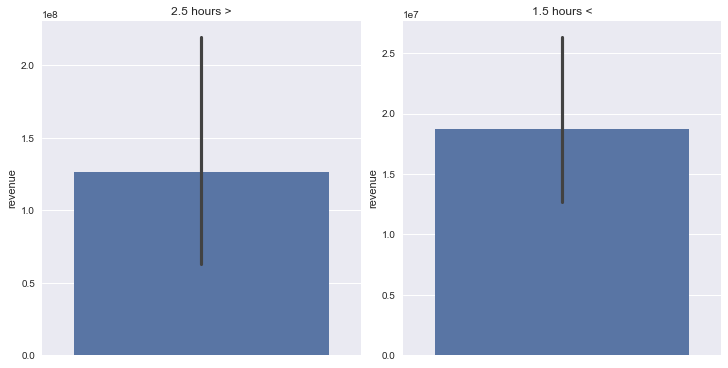

In [316]:
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.5,0.5]})
sns.barplot(data=rt25_df, y='revenue',ax = ax).set(title='2.5 hours >')
b=sns.barplot(data=rt15_df, y='revenue',ax = ax_bar).set(title='1.5 hours <')
